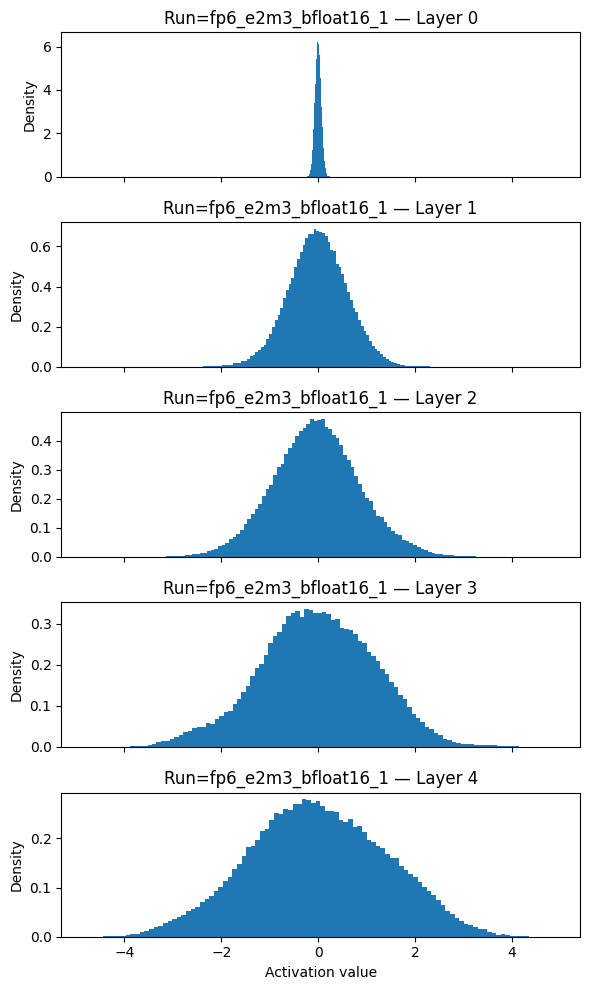

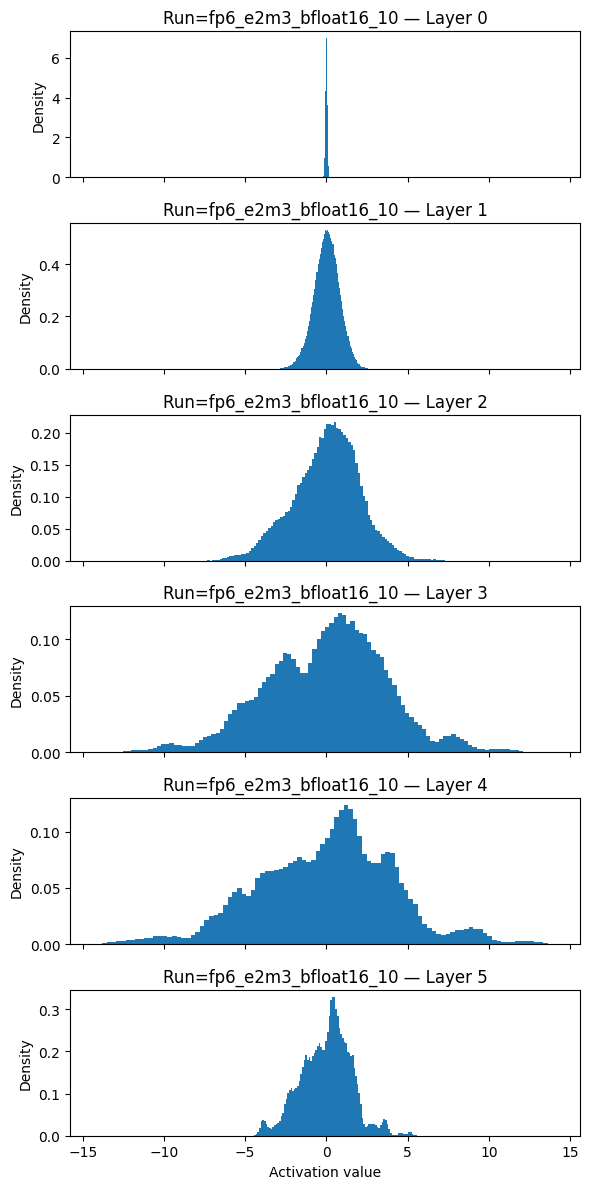

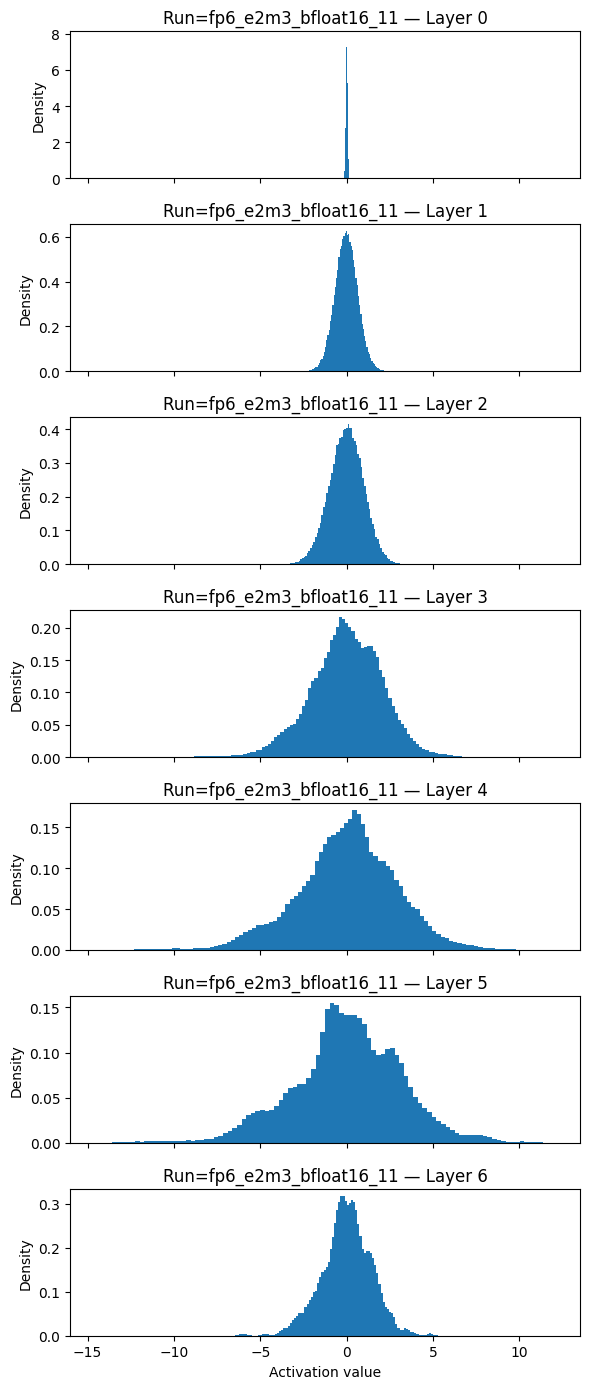

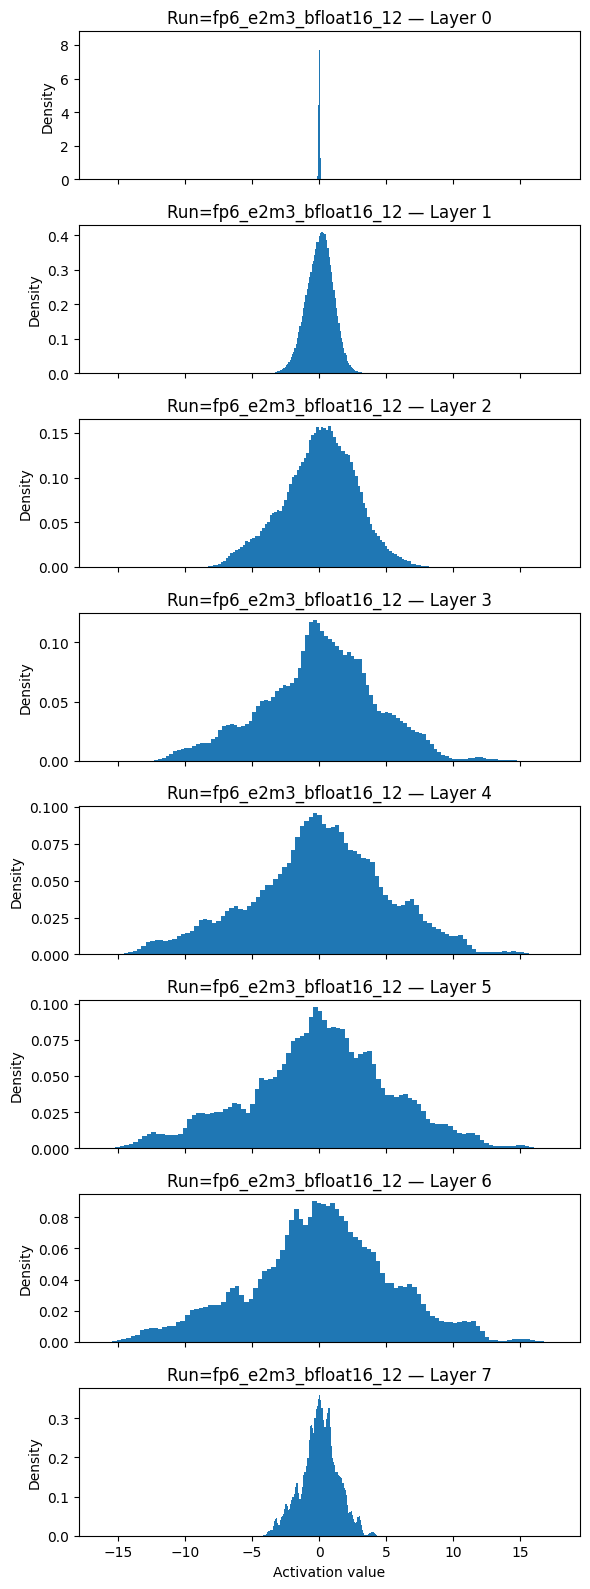

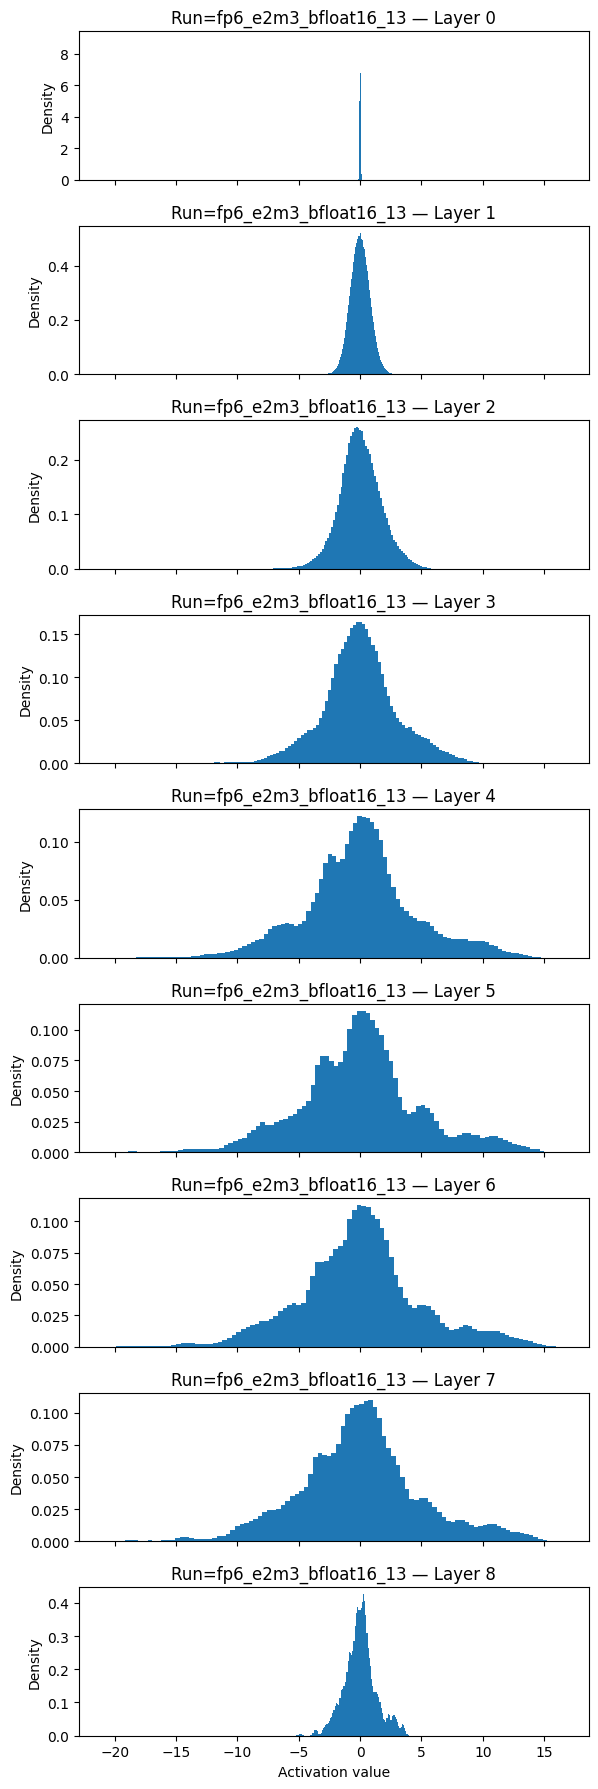

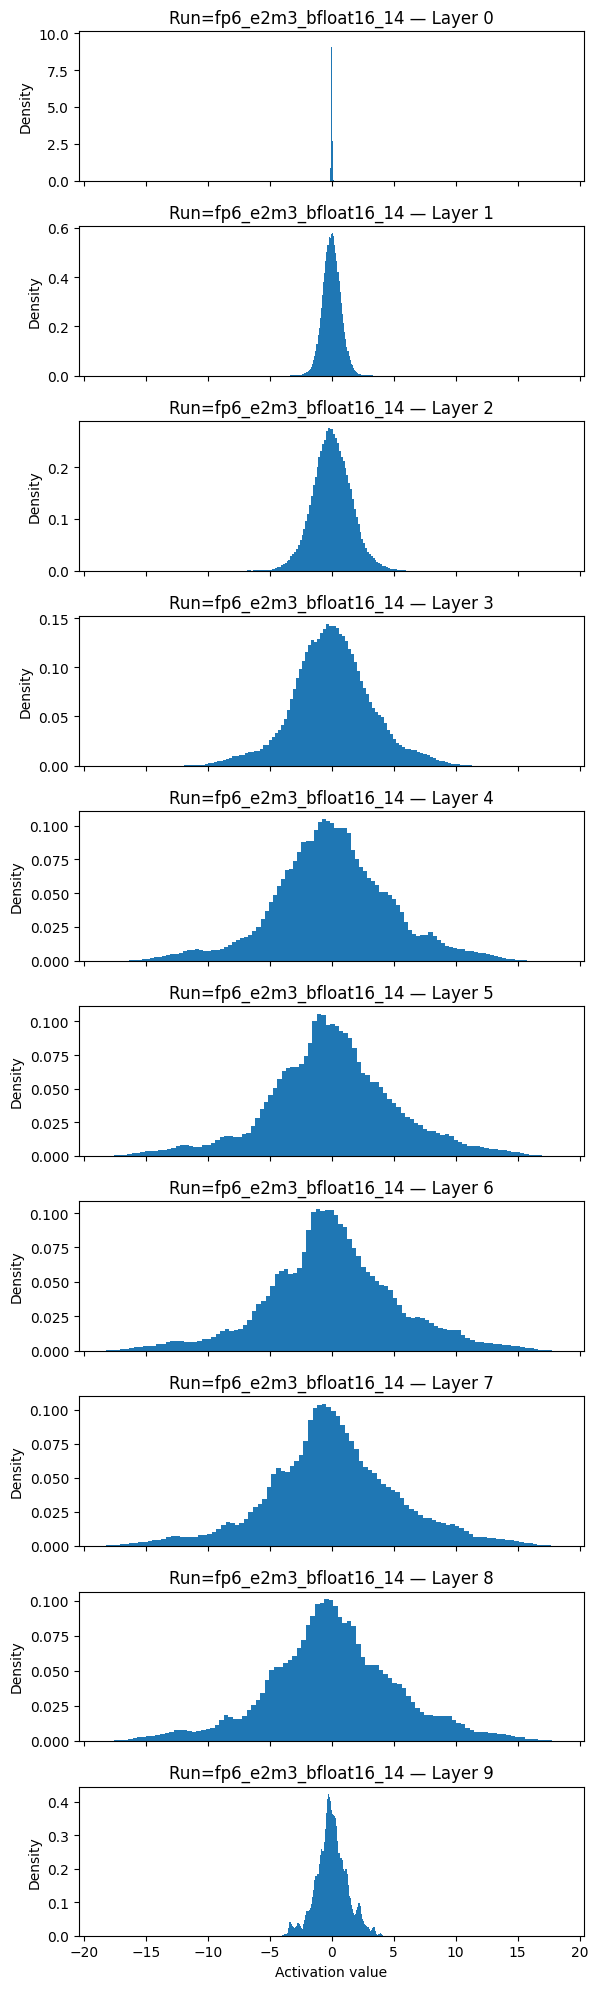

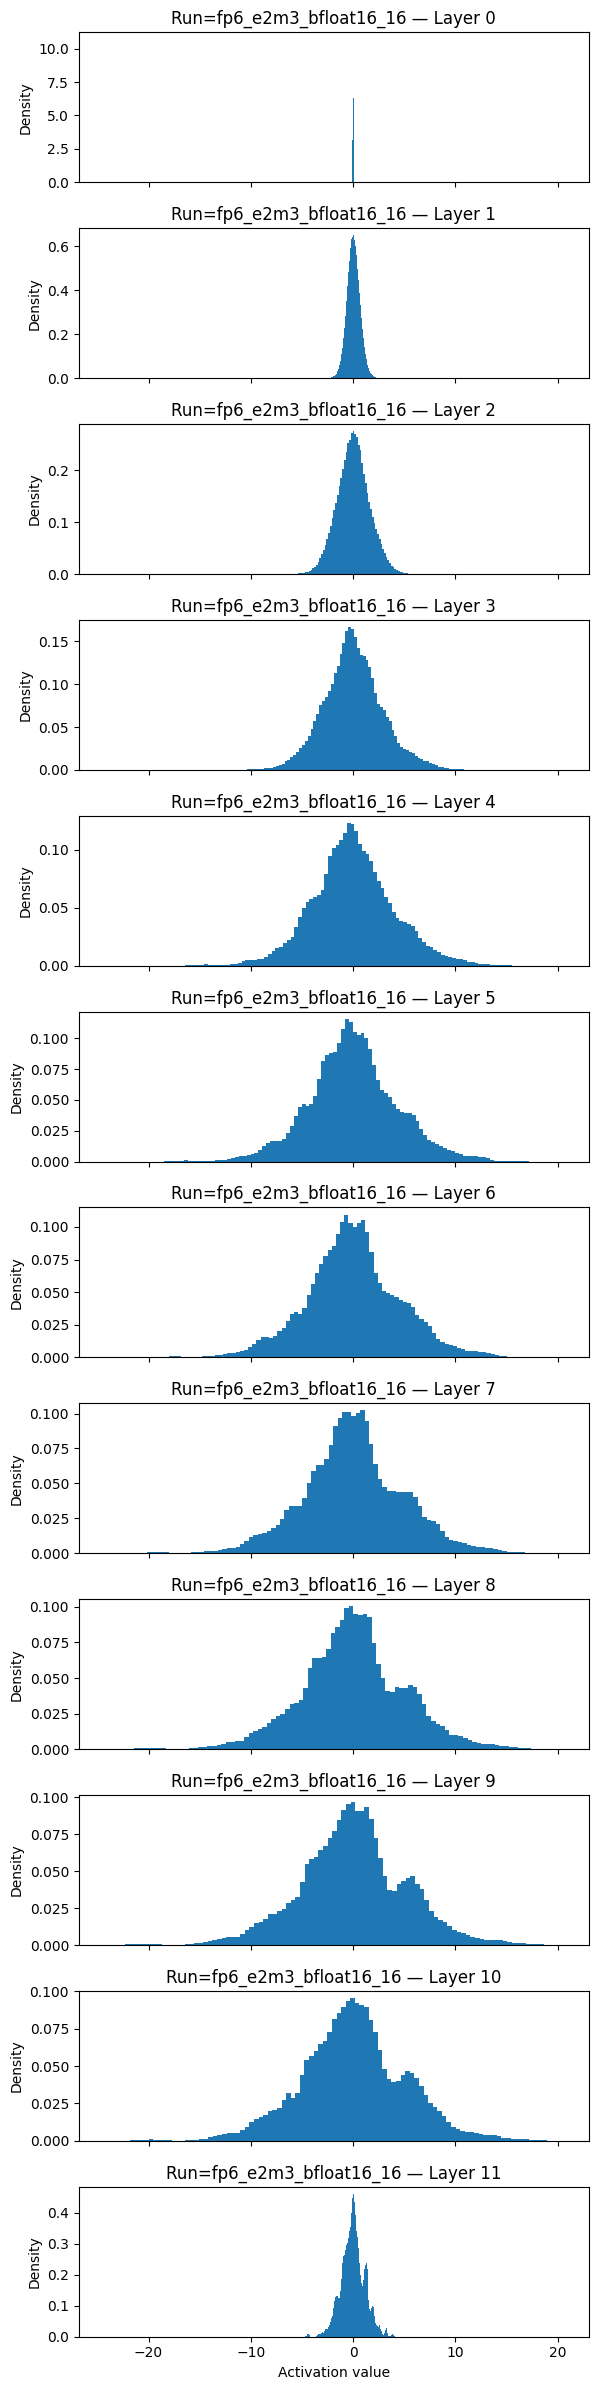

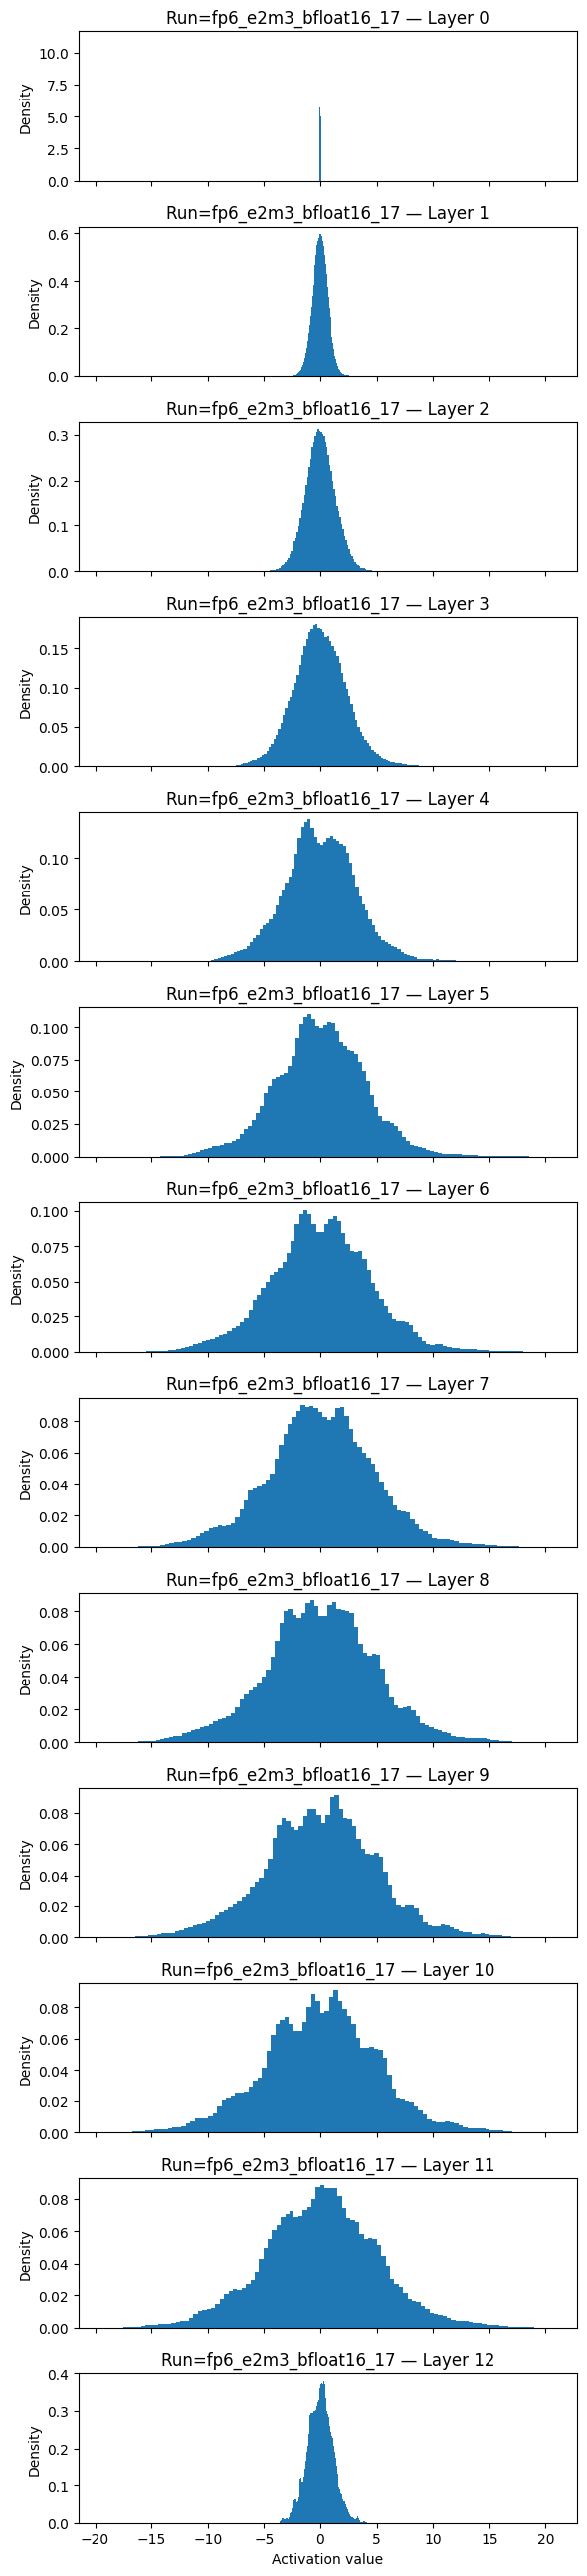

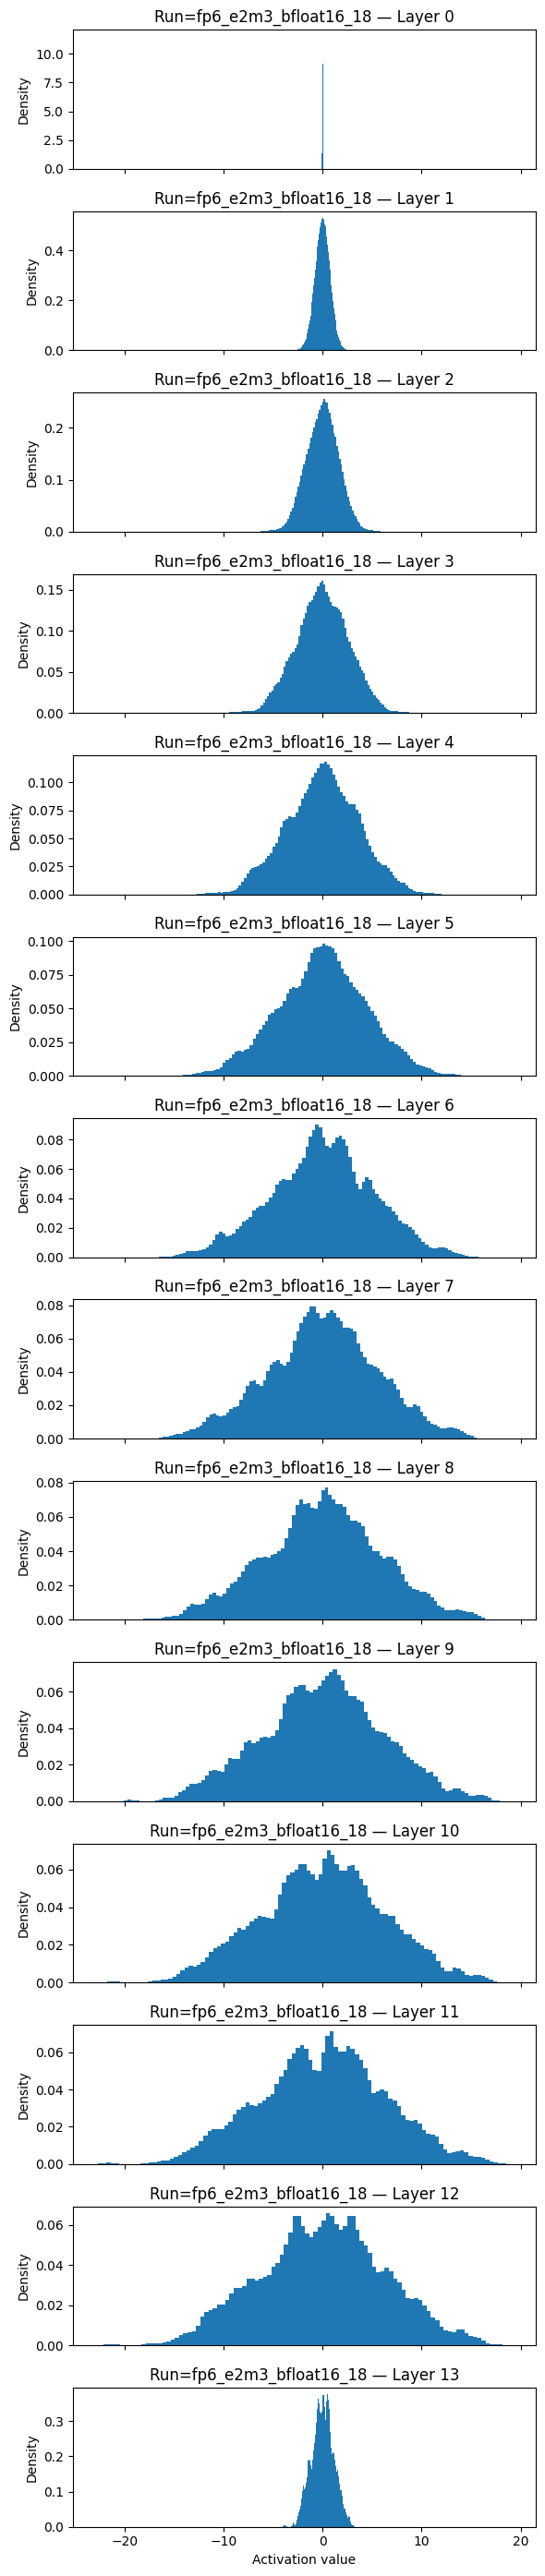

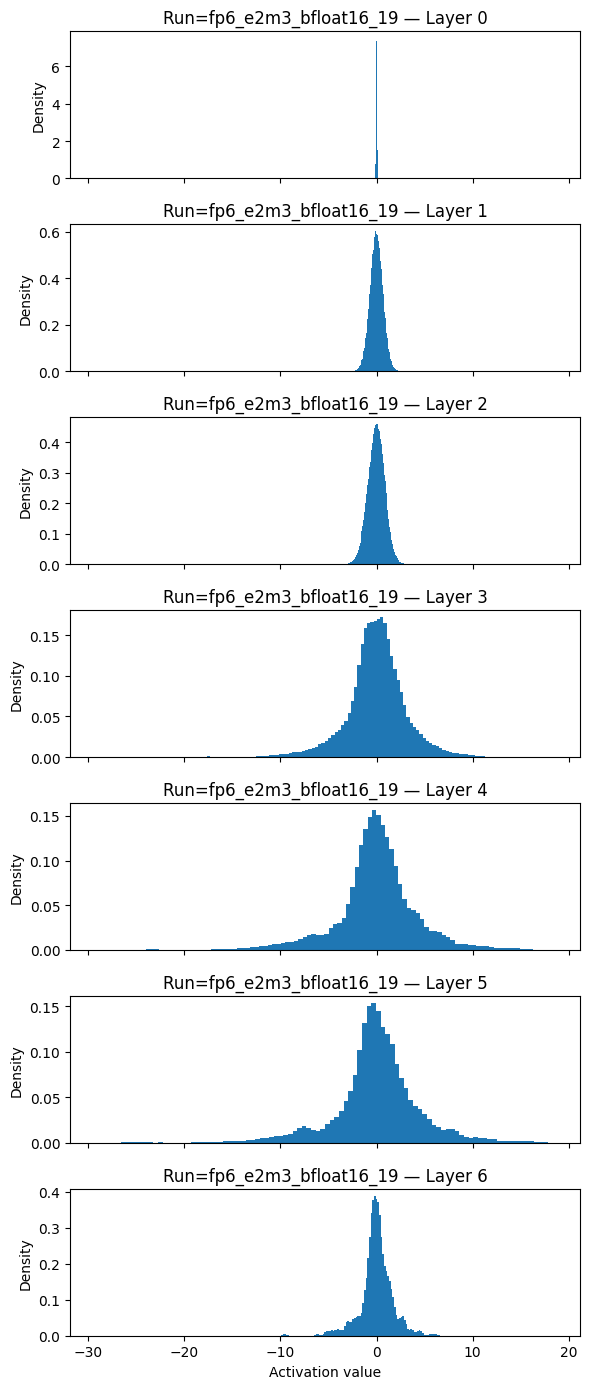

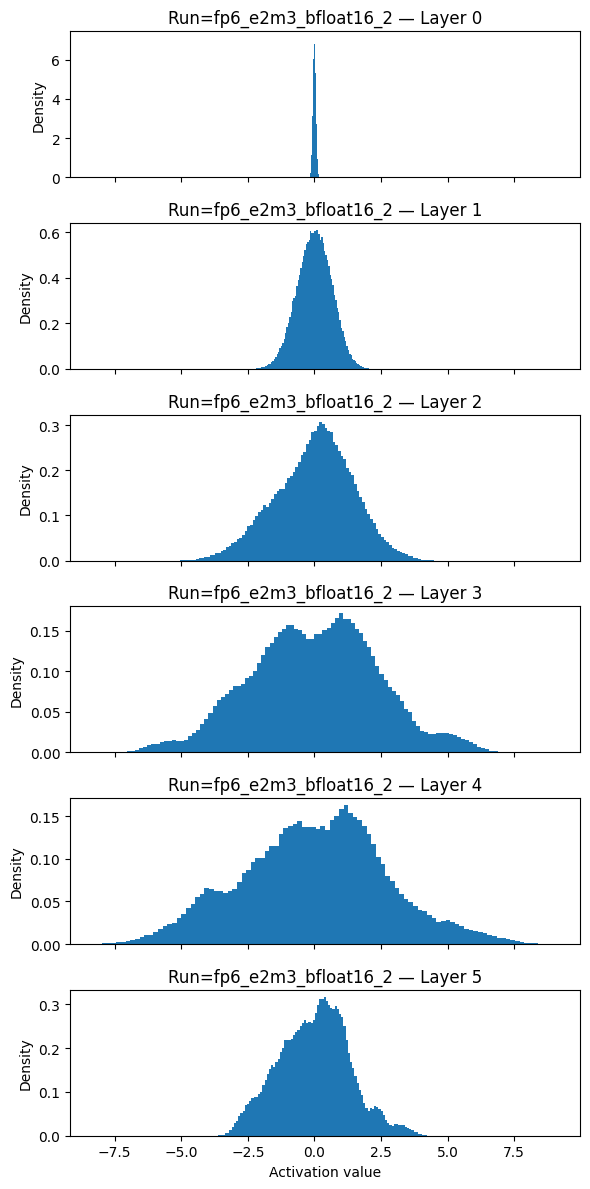

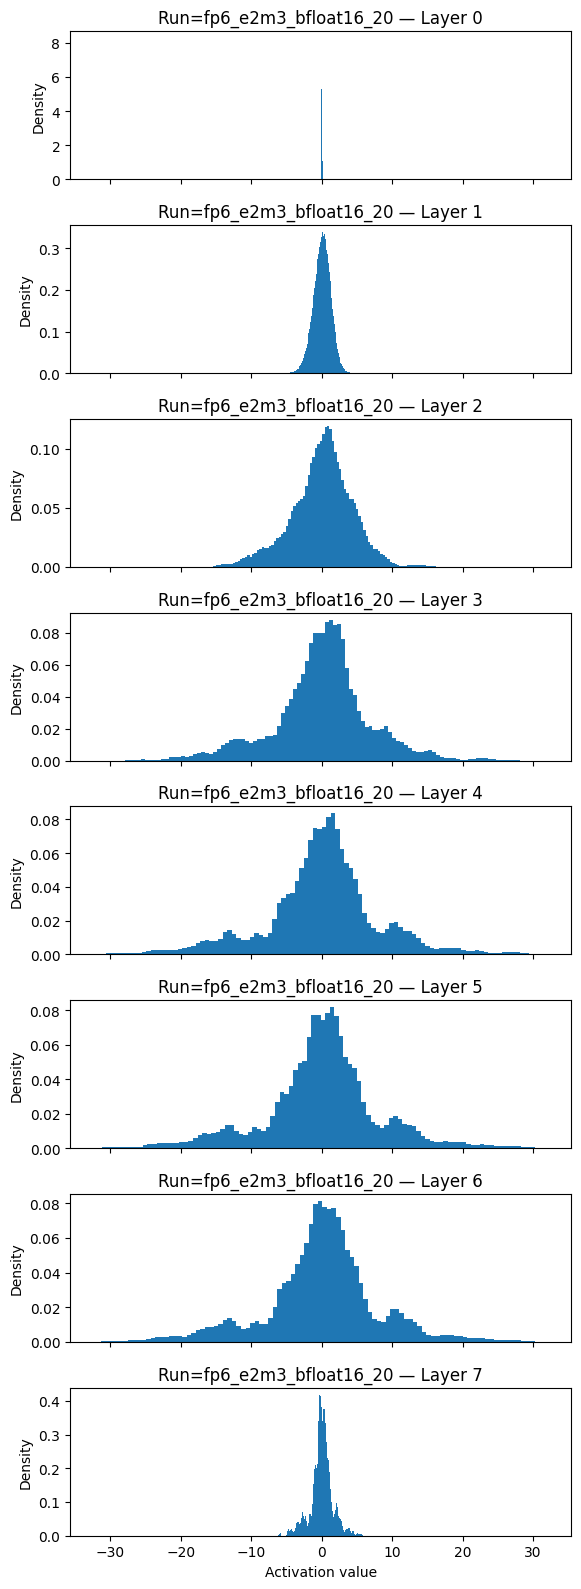

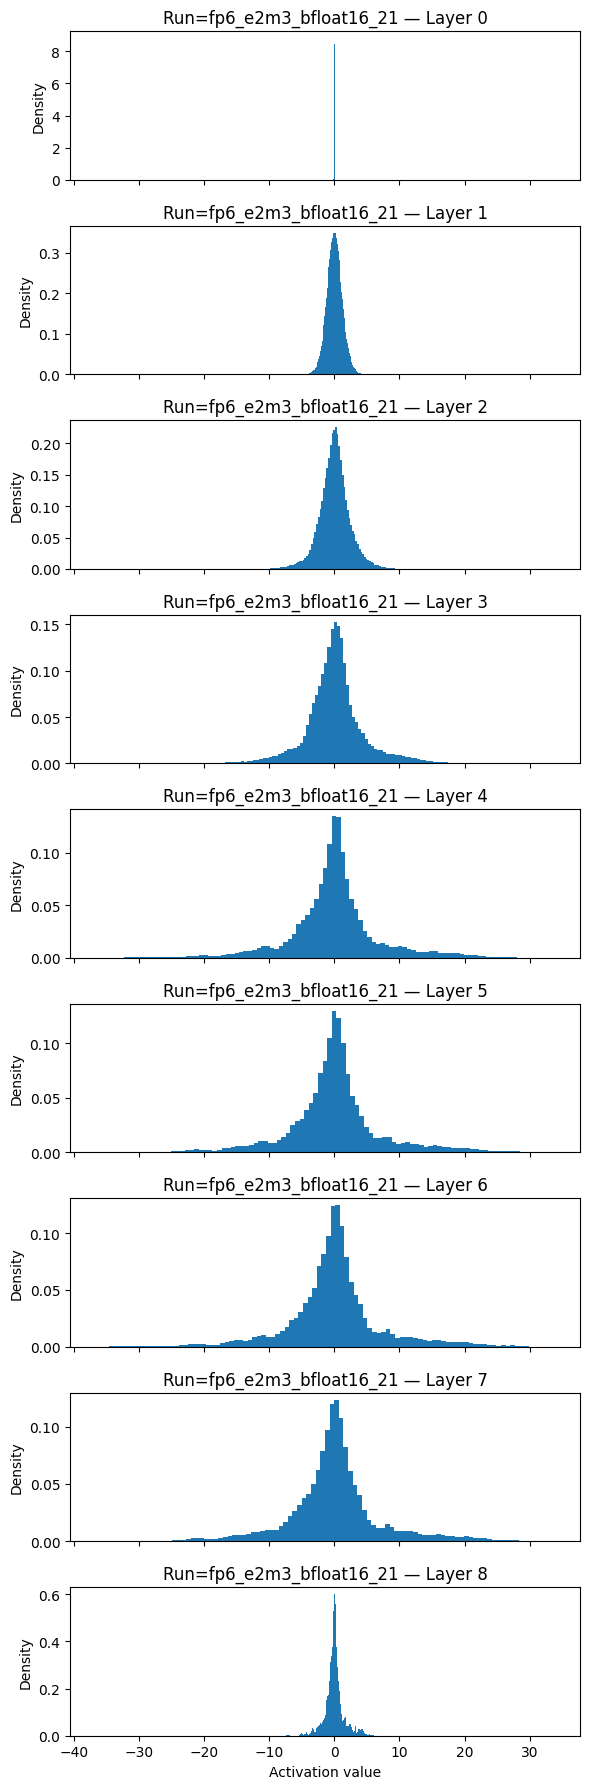

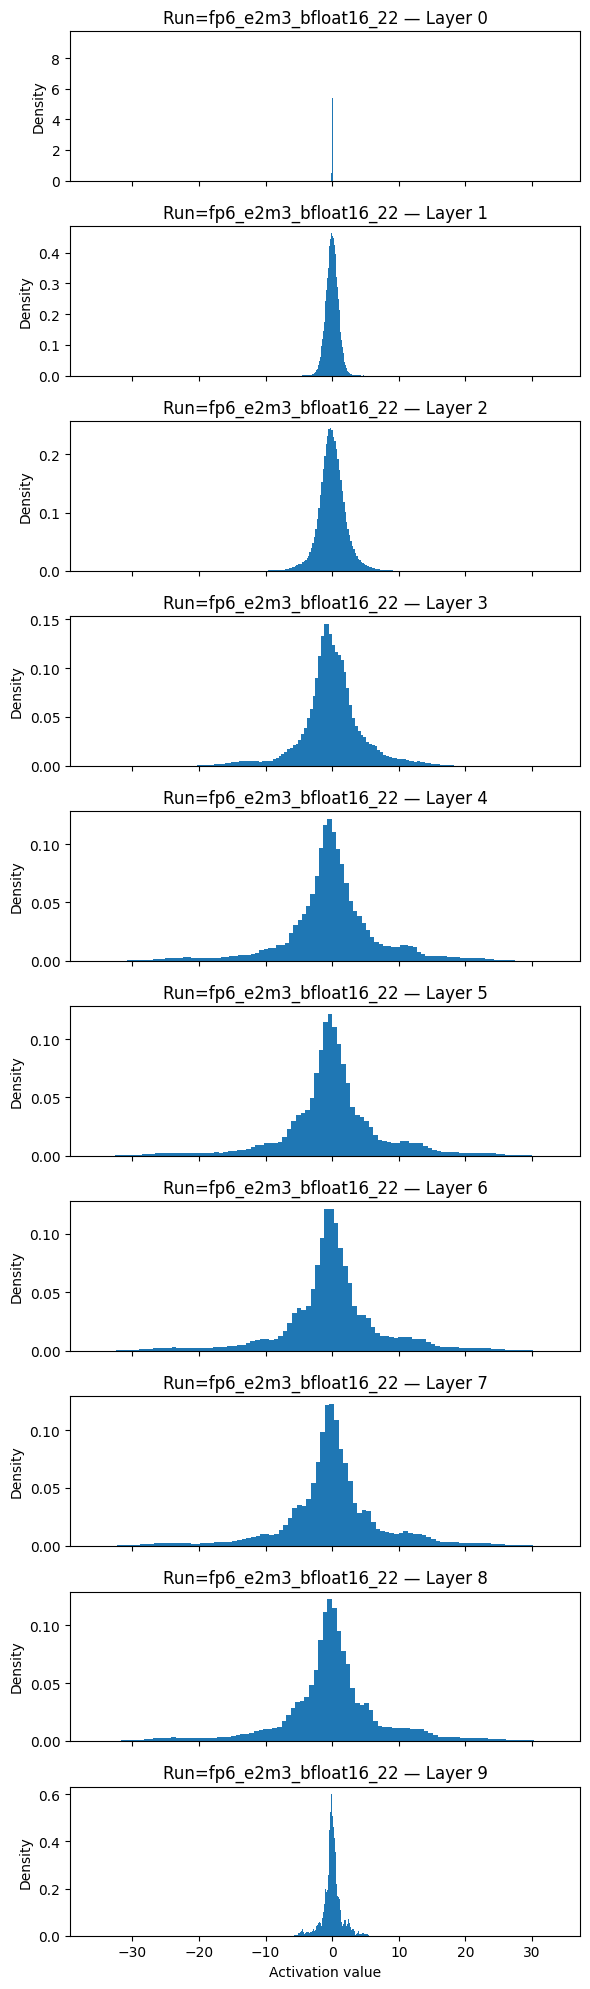

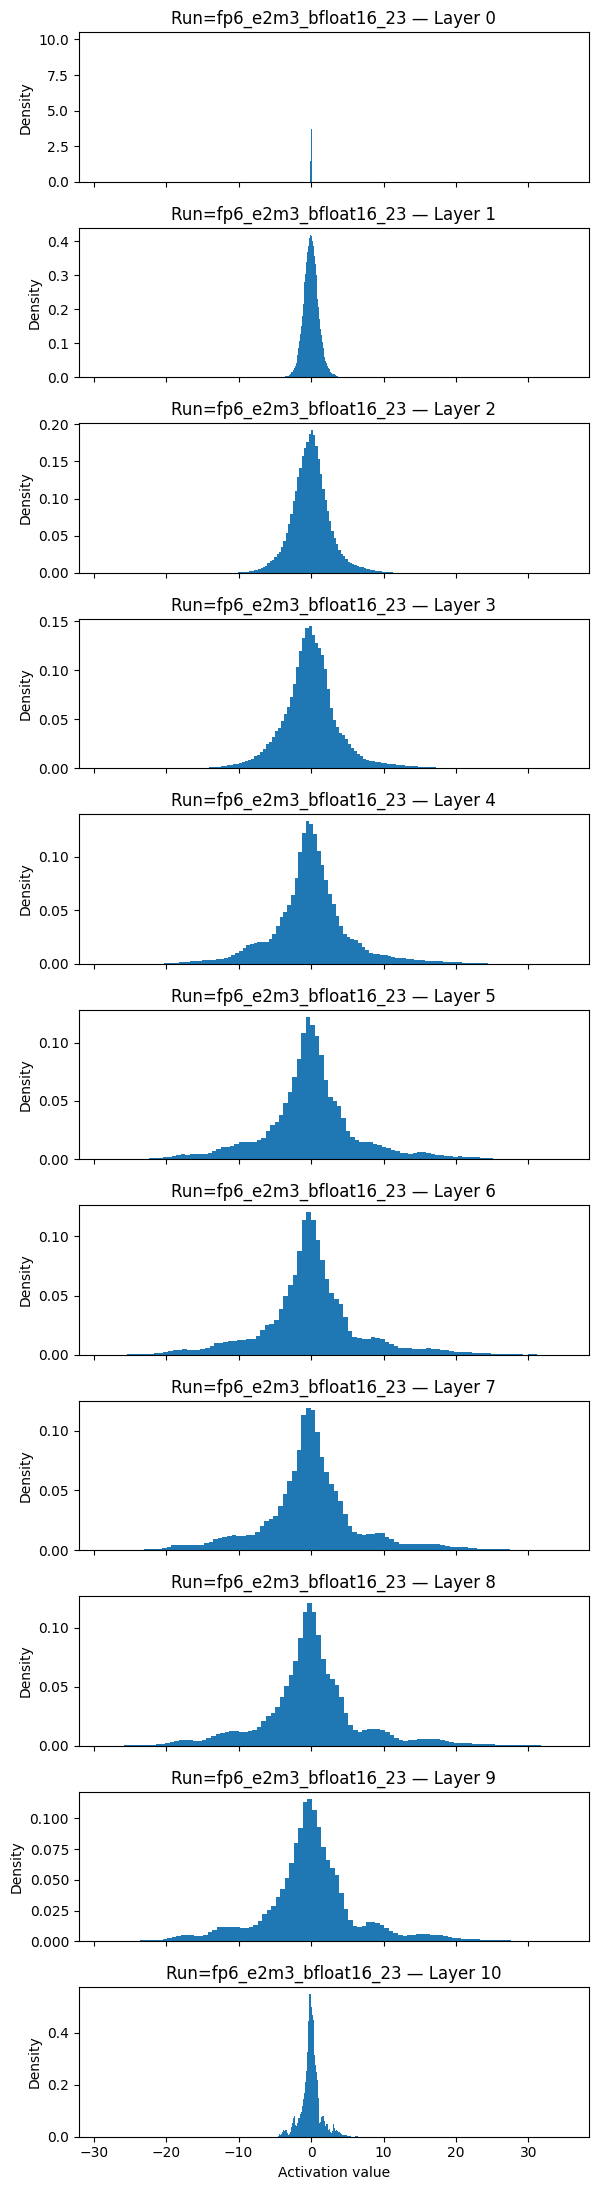

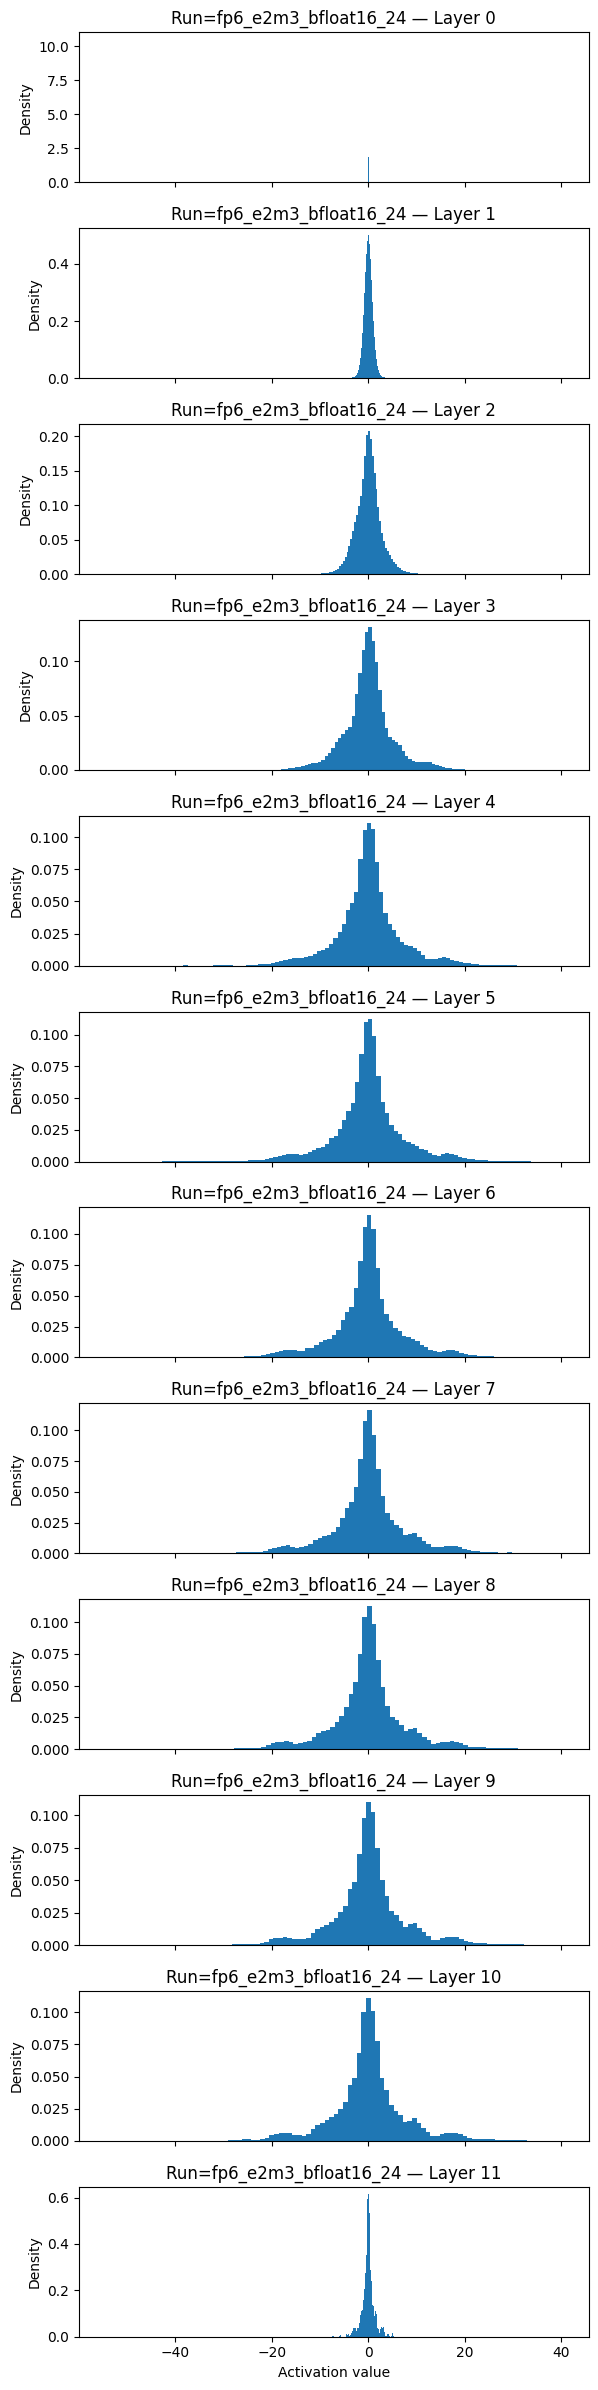

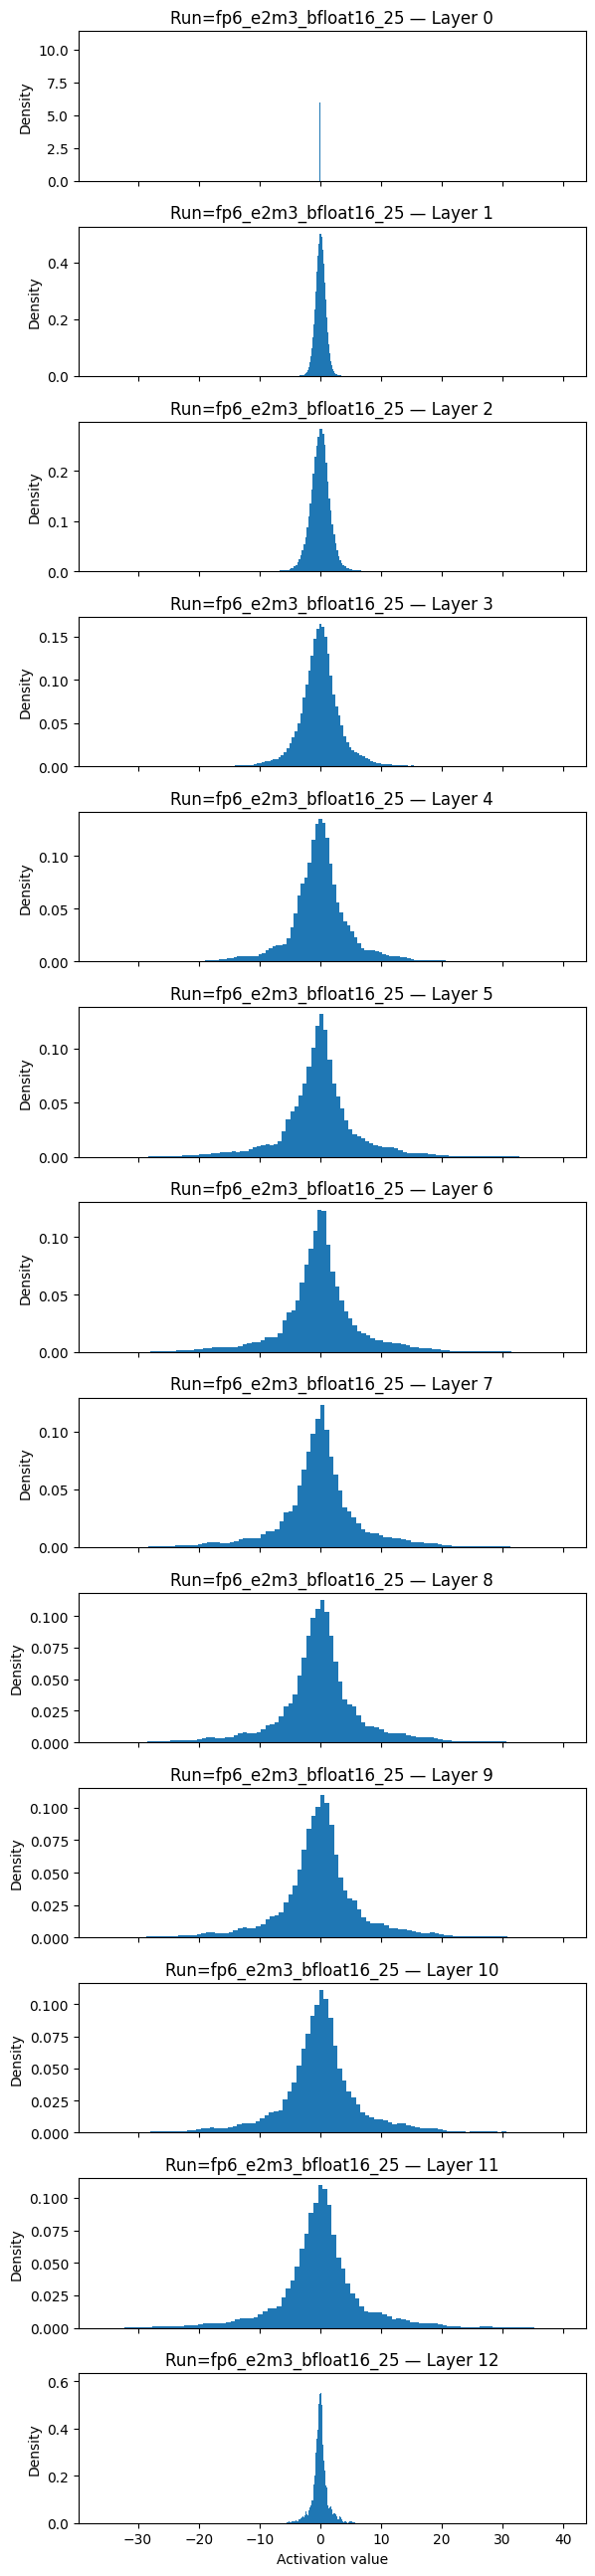

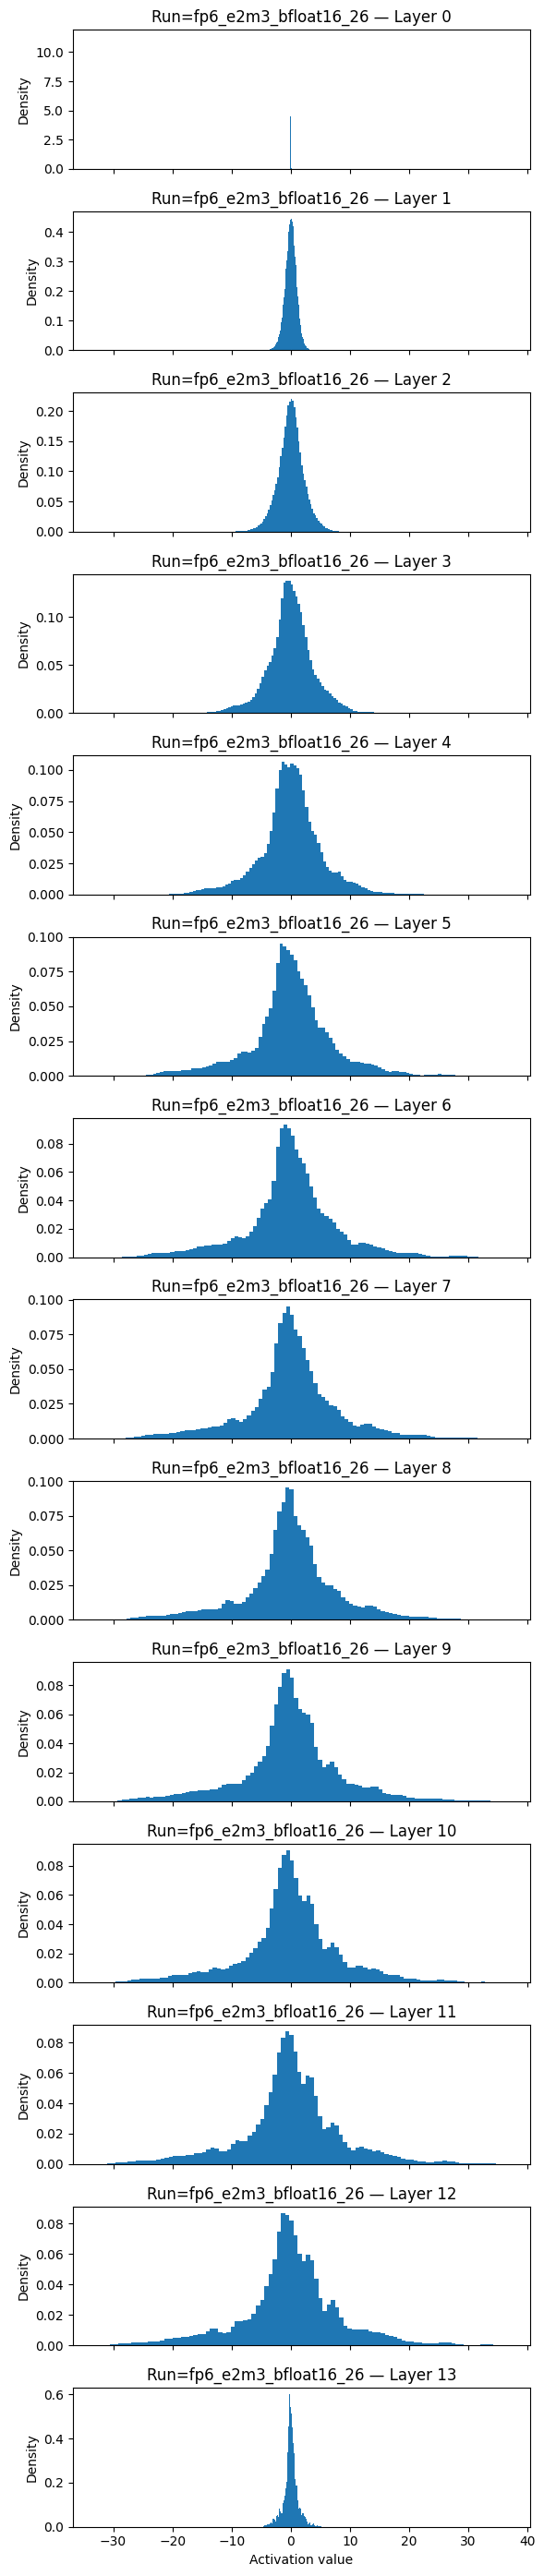

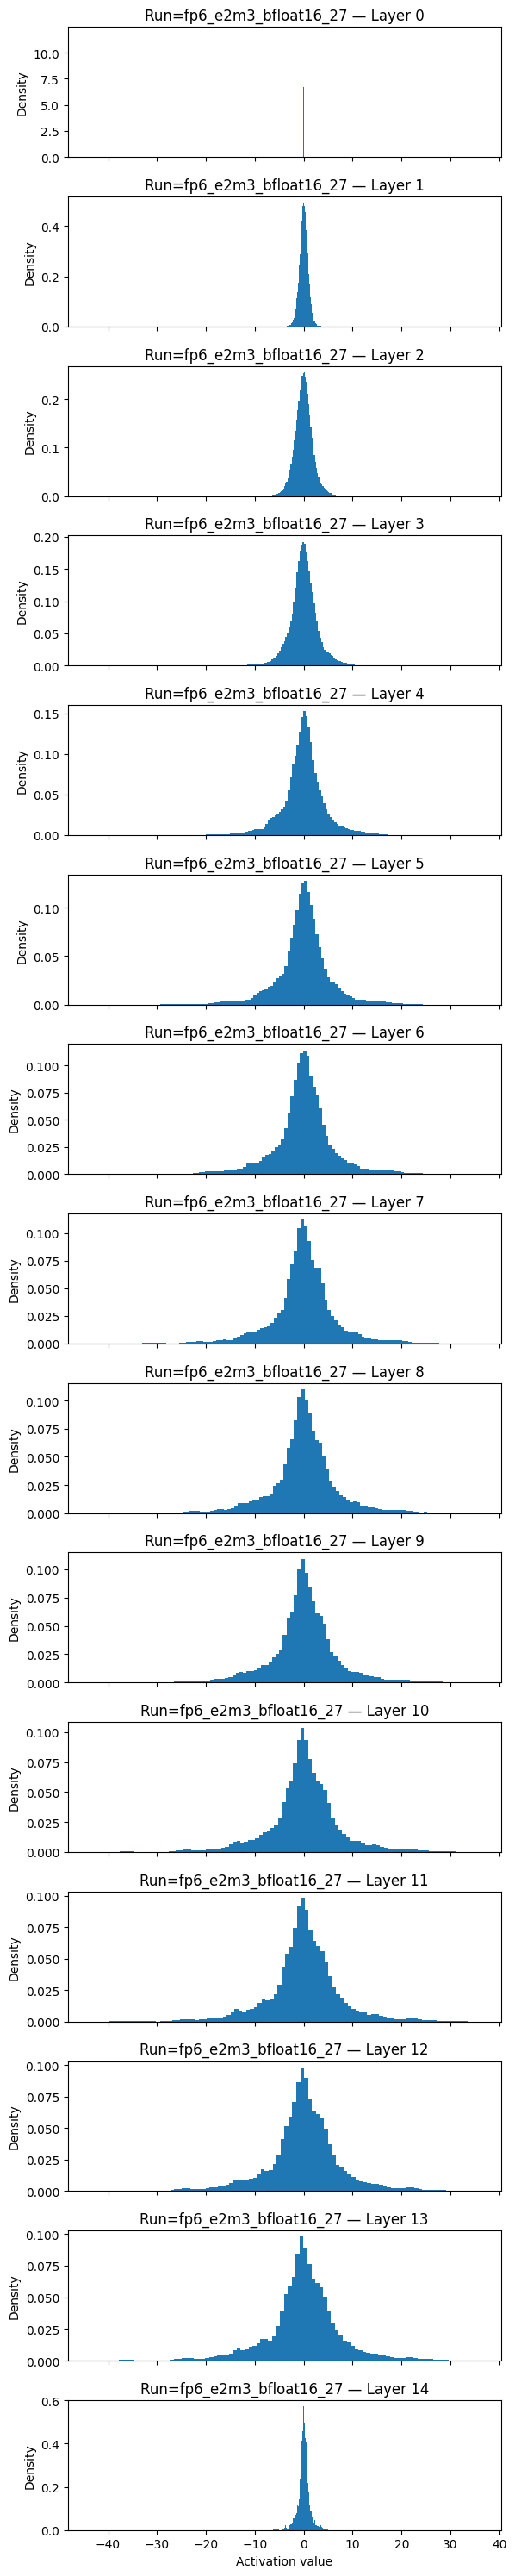

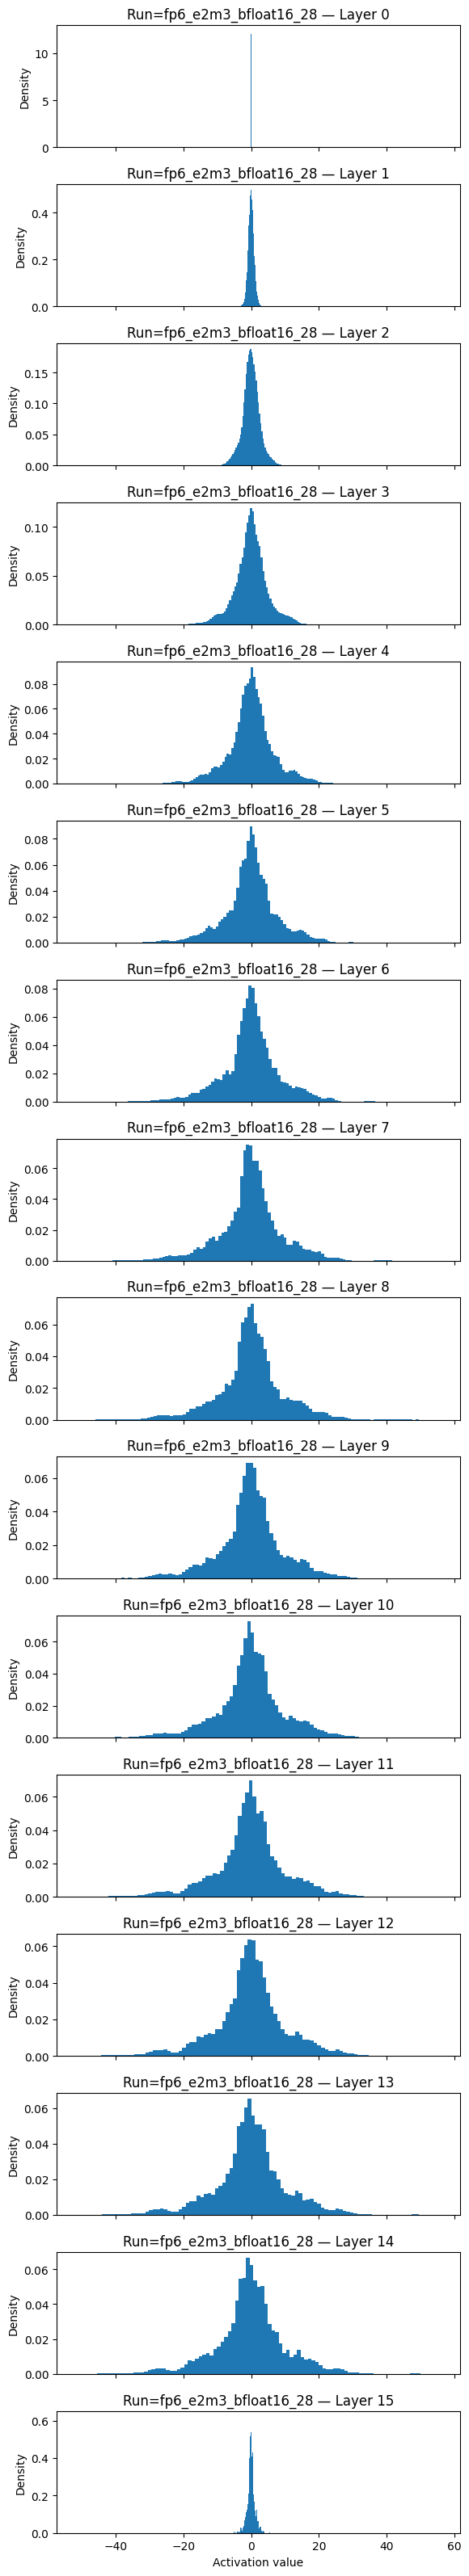

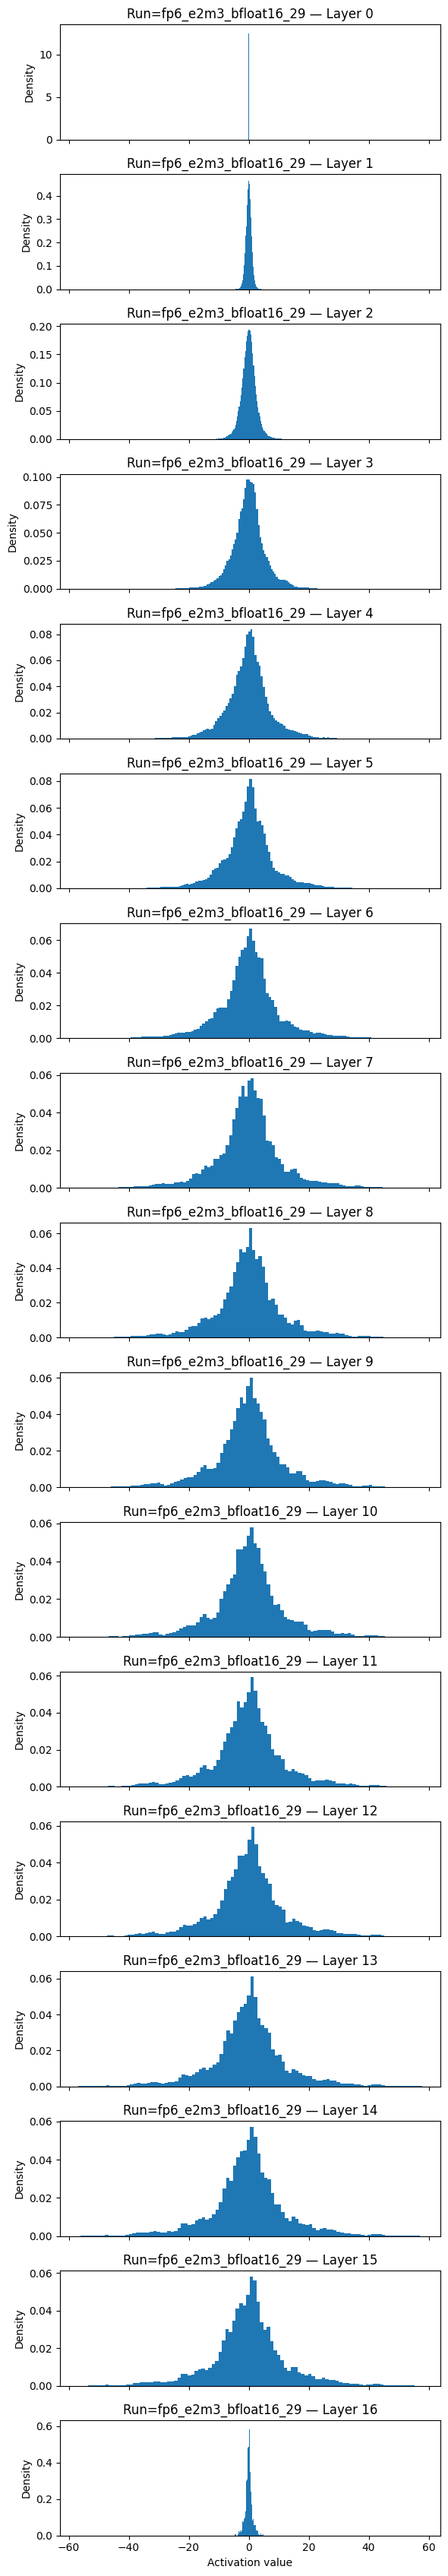

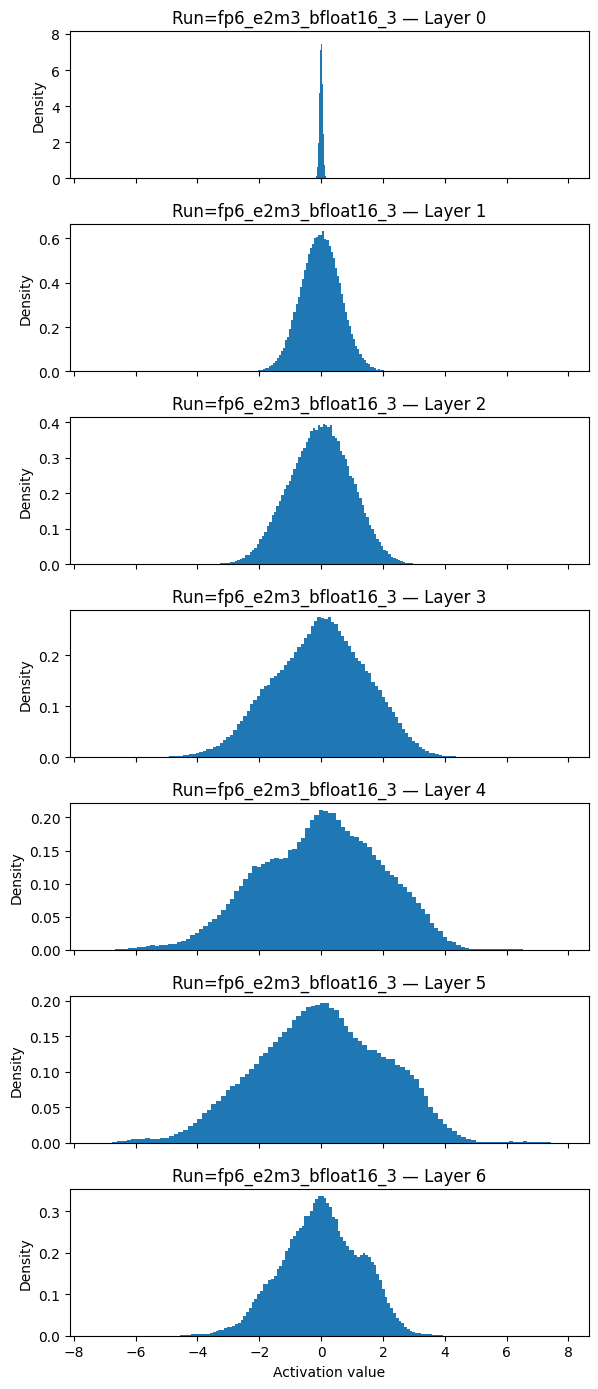

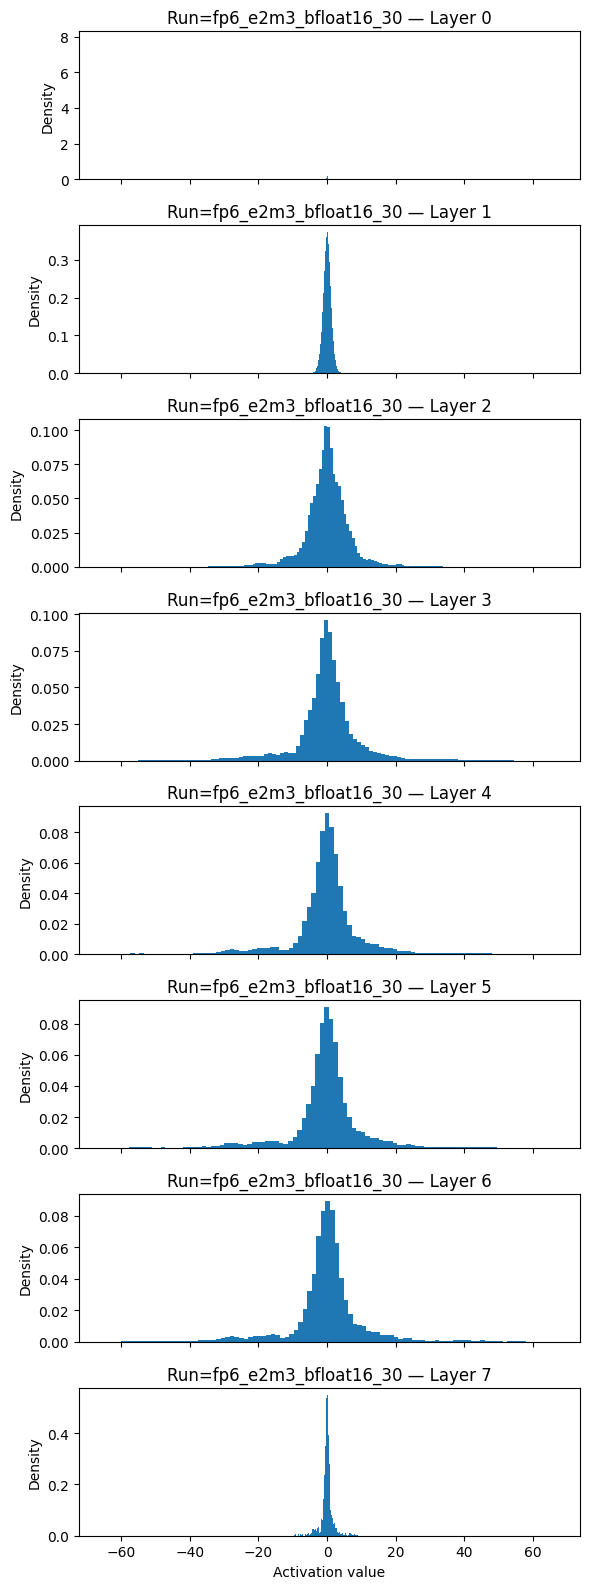

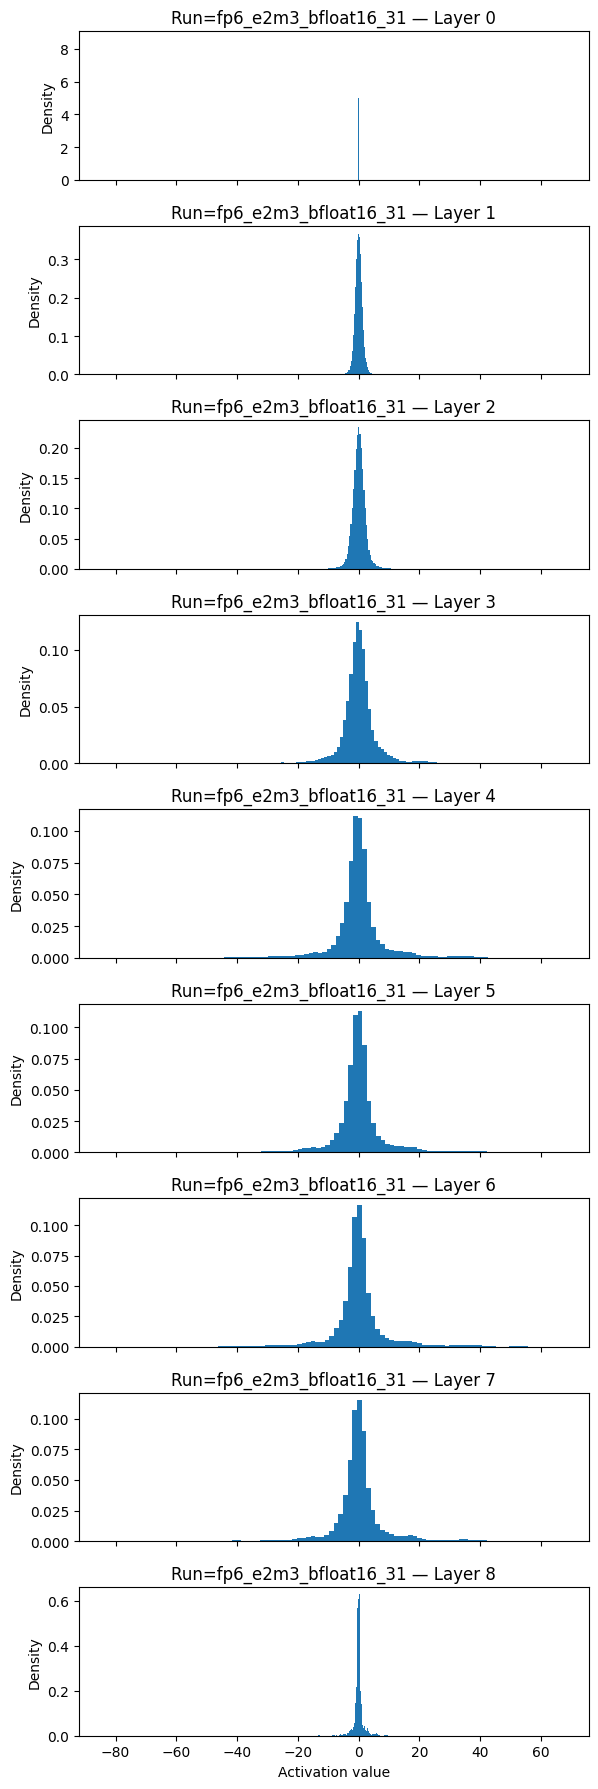

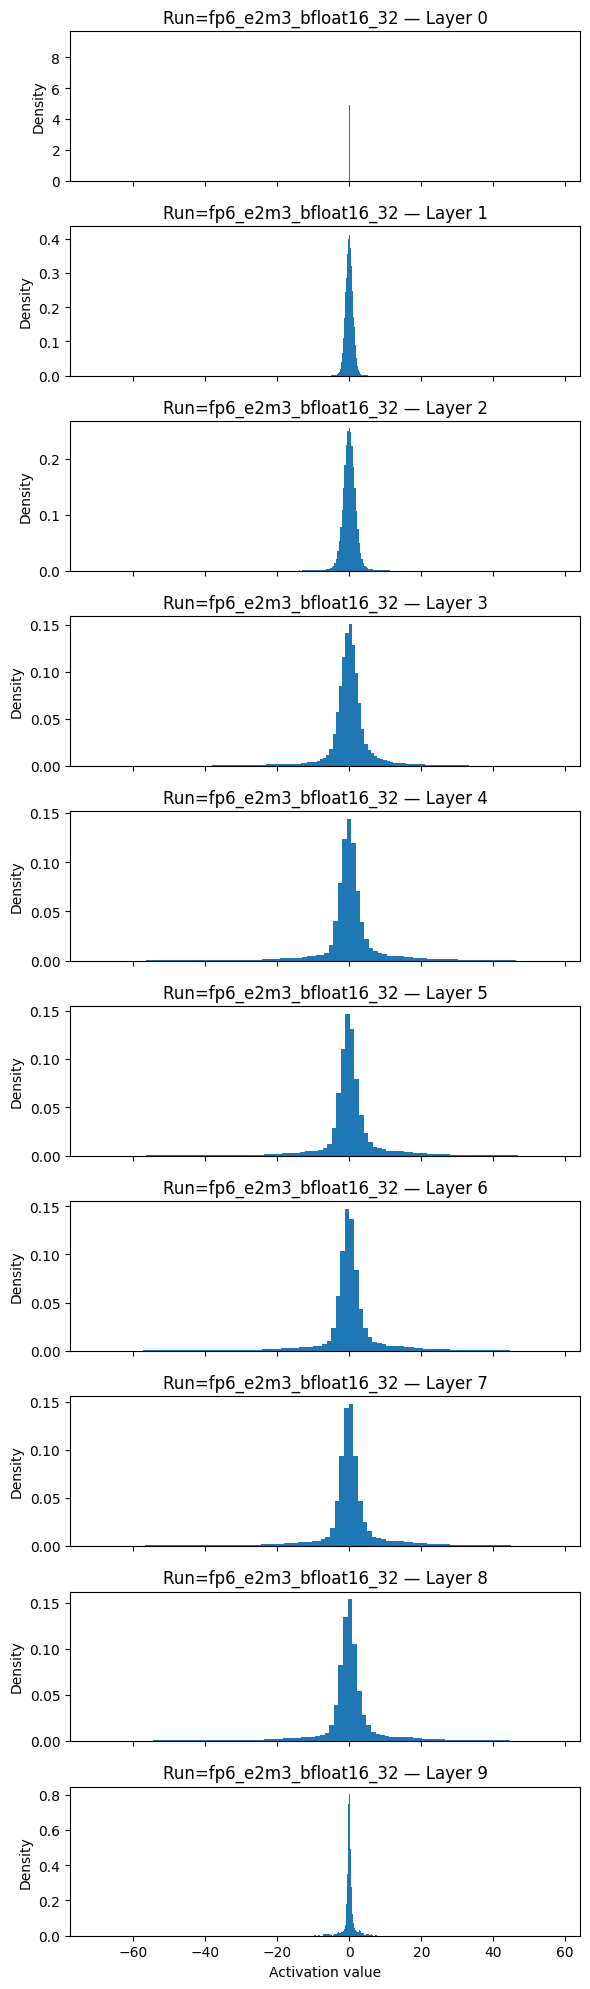

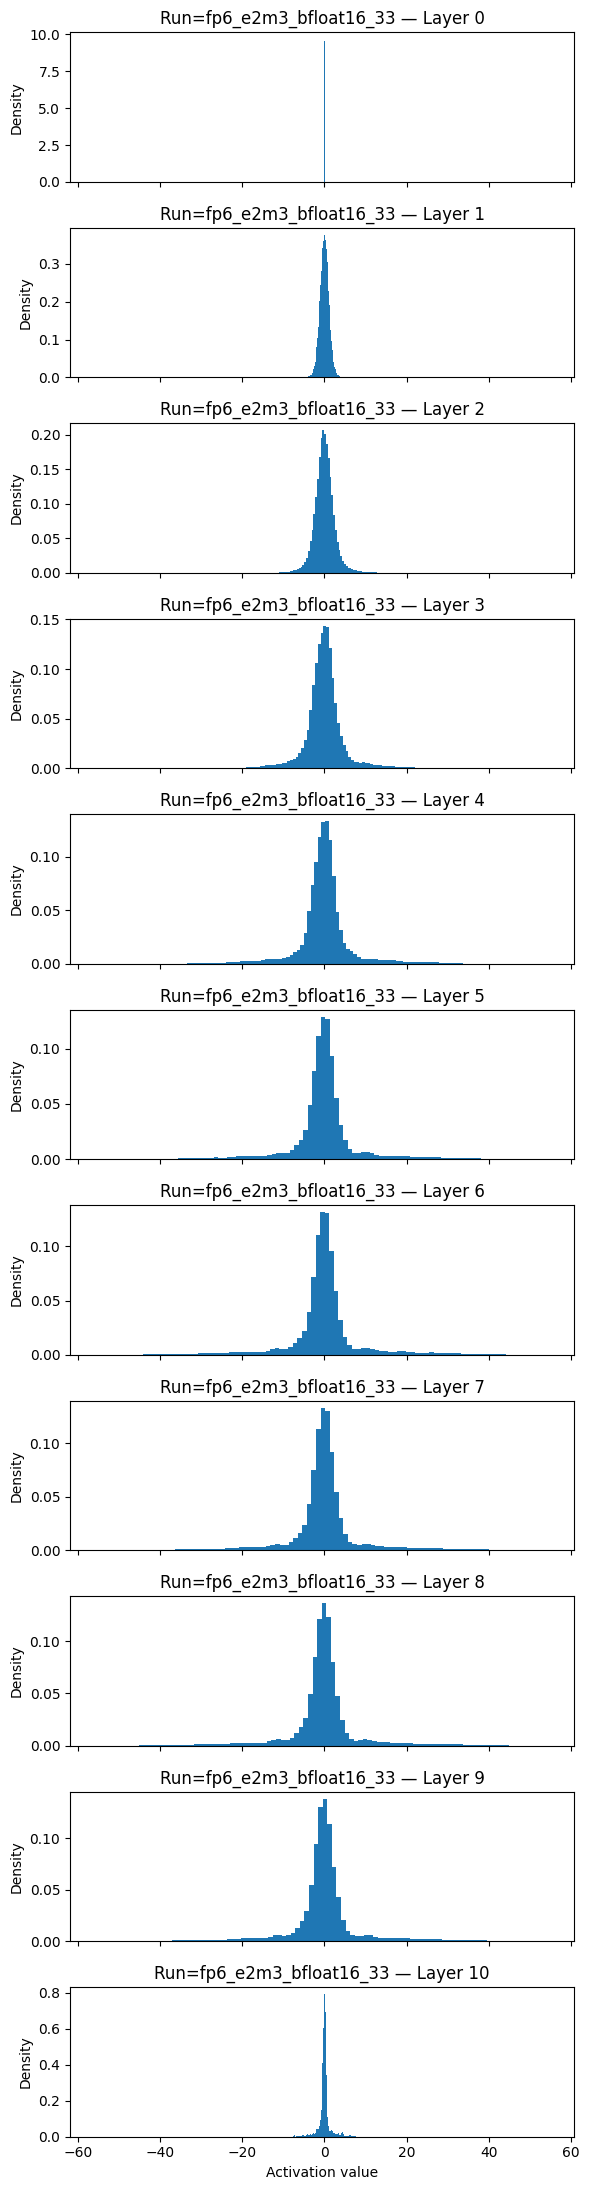

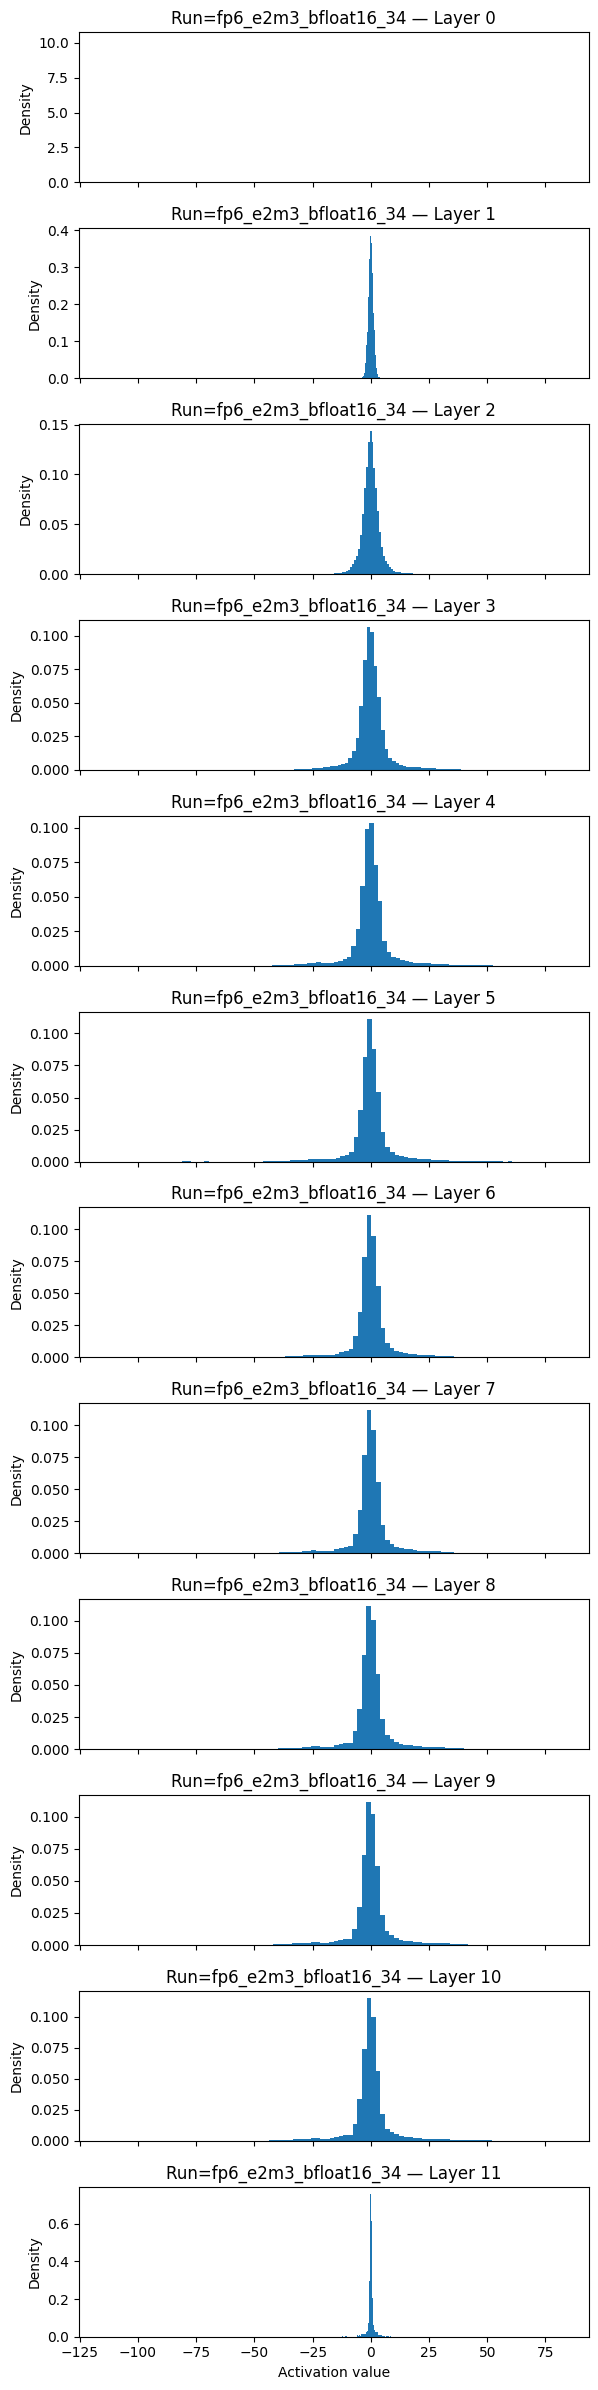

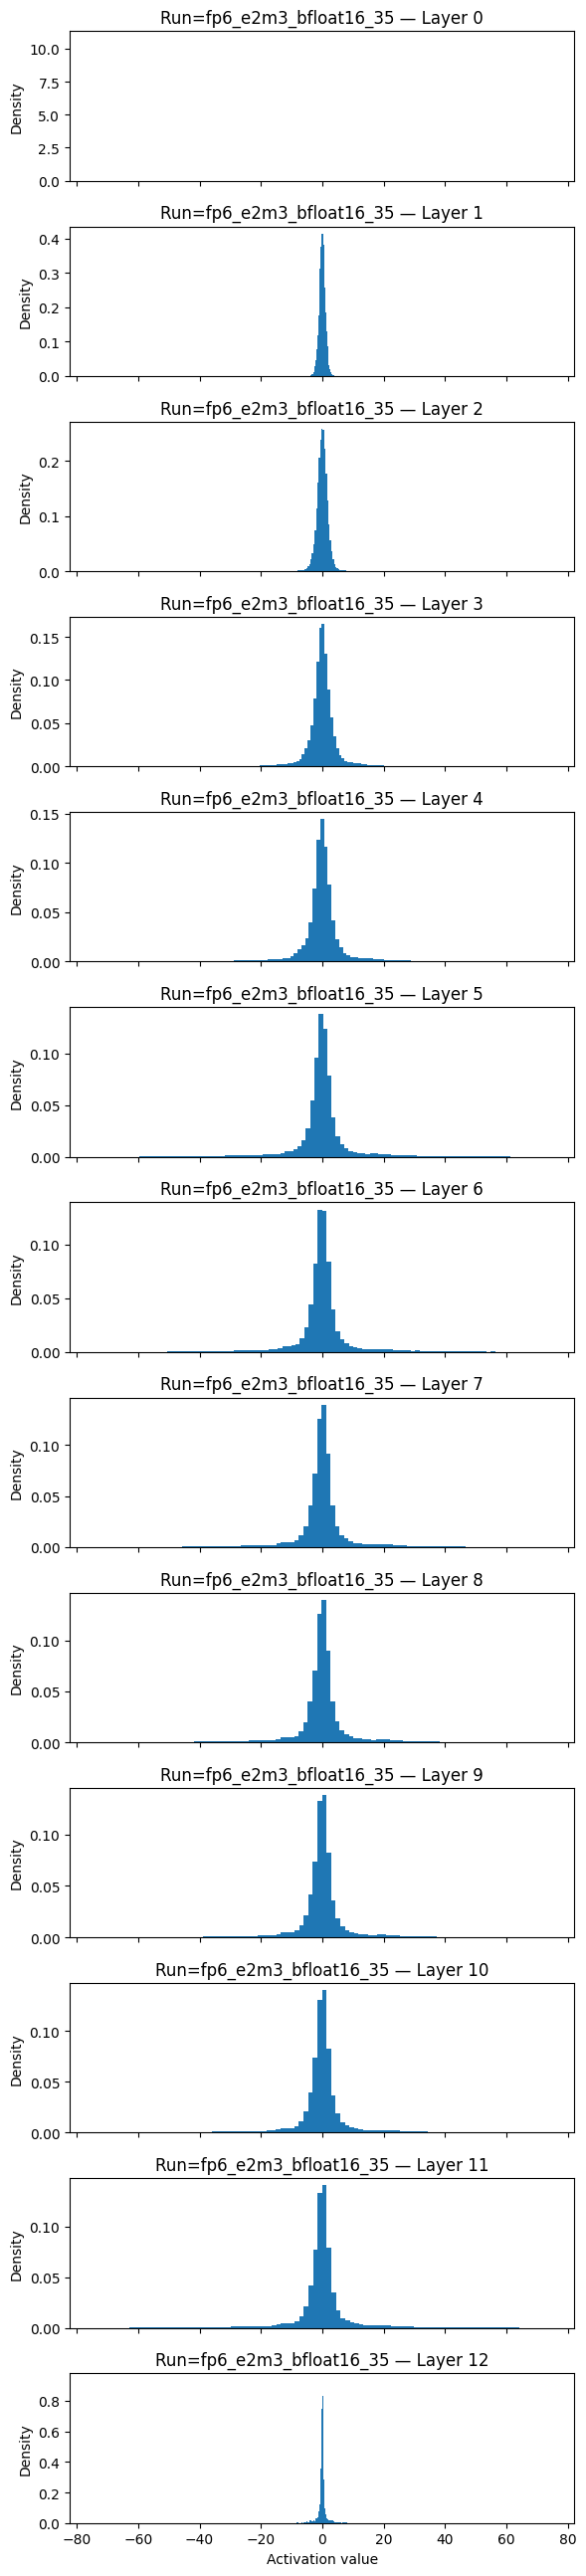

KeyboardInterrupt: 

In [ ]:
import os
import glob
import yaml
import torch
import matplotlib.pyplot as plt

from olmo.model import OLMo, OLMoOutput
from olmo.config import ModelConfig, ActivationType, BlockType, LayerNormType

DEVICE = 'cuda:2'

BASE_DIR = '/n/netscratch/kempner_dev/Lab/nikhilanand/ckpts'
PATTERN  = 'fp6_e2m3_bfloat16_*'

for run_path in sorted(glob.glob(os.path.join(BASE_DIR, PATTERN))):
    ckpt_dir = os.path.join(run_path, 'latest-unsharded')
    if not os.path.isdir(ckpt_dir):
        continue

    with open(os.path.join(ckpt_dir, 'config.yaml')) as f:
        cfg = yaml.safe_load(f)

    mcfg = cfg['model'].copy()

    mcfg['activation_type']    = ActivationType[    mcfg['activation_type']   ]
    mcfg['block_type']         = BlockType[         mcfg['block_type']        ]
    mcfg['layer_norm_type']    = LayerNormType[    mcfg['layer_norm_type']   ]
    mcfg['init_device'] = 'cpu'
    seq_len    = mcfg['context_length']
    vocab_size = mcfg['vocab_size']

    model_cfg = ModelConfig(**mcfg)

    model = OLMo(model_cfg)
    model.to('cpu')
    state = torch.load(os.path.join(ckpt_dir, 'model.pt'),
                       map_location='cpu')
    model.load_state_dict(state)
    model.eval() #
    #model.to(DEVICE)


    d_model = mcfg.get('d_model')
    x = torch.randint(
        low=0,
        high=vocab_size,
        size=(1, seq_len),
        dtype=torch.long,
        device='cpu',
    )

    with torch.no_grad():
        out: OLMoOutput = model(
            x,
            output_hidden_states=True,
            last_logits_only=False,
        )

    hs = out.hidden_states  

    n_layers = len(hs)
    fig, axes = plt.subplots(n_layers, 1, figsize=(6, 2*n_layers), sharex=True)
    for idx, h in enumerate(hs):
        data = h.detach().cpu().view(-1).numpy()
        ax = axes[idx] if n_layers > 1 else axes
        ax.hist(data, bins=100, density=True)
        ax.set_title(f'Run={os.path.basename(run_path)} — Layer {idx}')
        ax.set_ylabel('Density')
    axes[-1].set_xlabel('Activation value')
    plt.tight_layout()
    plt.show()


In [5]:
model

OLMo(
  (transformer): ModuleDict(
    (wte): Embedding(32100, 320)
    (emb_drop): Dropout(p=0.0, inplace=False)
    (ln_f): LayerNorm()
    (blocks): ModuleList(
      (0-4): 5 x OLMoSequentialBlock(
        (dropout): Dropout(p=0.0, inplace=False)
        (k_norm): LayerNorm()
        (q_norm): LayerNorm()
        (act): GELU(approximate='none')
        (attn_out): Linear(in_features=320, out_features=320, bias=False)
        (ff_out): Linear(in_features=1280, out_features=320, bias=False)
        (rotary_emb): RotaryEmbedding()
        (attn_norm): LayerNorm()
        (ff_norm): LayerNorm()
        (att_proj): Linear(in_features=320, out_features=960, bias=False)
        (ff_proj): Linear(in_features=320, out_features=1280, bias=False)
      )
    )
    (ff_out_last): Linear(in_features=320, out_features=32100, bias=False)
  )
)